# Make colorful dot graphs out of texts

I like to present data in different ways. Most of the time the best way to show the data is with simple bar charts or line charts. Sometimes, however, unconventional visualizations may generate new insights and encourage lateral thinking. And they are often more fun to look at than bar charts!

Here I will show how to generate a chart that shows a text as colorized dots, where each dot represents a letter. Hardly the best way to show text - the output is extremely hard to read, and it does not lead to any new insights. But it looks nice, and might encourage some more thinking on an interesting text. The text we will focus on is Abraham Lincoln's Gettysburg Address.

Cells that end with a semicolon have suppressed output: the semicolon would not be included if the code were to run in R Studio for instance.

## Loading and cleaning the text
We start by loading the relevant text. Here I've entered it as a long string directly in the code - it is probably more practical to keep it as a .txt file and load it, but I wanted the code to be self-contained here. The next step is to remove punctuation, with the `str_replace_all` command. I then turn the text into lowercase.

In [143]:
# Load packages
library(tidyverse)
library(gridExtra)
library(RColorBrewer)
library(ggpubr)

# Load title and text to use
titletext <- "THE GETTYSBURG ADDRESS"

text <- "Four score and seven years ago our fathers brought forth
on this continent, a new nation, conceived in Liberty, and
dedicated to the proposition that all men are created equal.

Now we are engaged in a great civil war, testing whether that nation,
or any nation so conceived and so dedicated, can long endure.
We are met on a great battle-field of that war. We have come to
dedicate a portion of that field, as a final resting place for
those who here gave their lives that that nation might live.
It is altogether fitting and proper that we should do this.

But, in a larger sense, we can not dedicate—we can not consecrate—
we can not hallow—this ground. The brave men, living and dead,
who struggled here, have consecrated it, far above our poor power
to add or detract. The world will little note, nor long remember
what we say here, but it can never forget what they did here.
It is for us the living, rather, to be dedicated here to the
unfinished work which they who fought here have thus far so nobly
advanced. It is rather for us to be here dedicated to the great
task remaining before us—that from these honored dead we take
increased devotion to that cause for which they gave the last full
measure of devotion—that we here highly resolve that these dead
shall not have died in vain—that this nation, under God, shall have
a new birth of freedom—and that government of the people, by the
people, for the people, shall not perish from the earth."

# Remove punctuation and numbers and transform to lowercase
cleaned <- str_replace_all(text, "[\t\r\n,.—-]", "") %>%
    str_replace_all(c("[0123456789]"), "") %>%
    str_replace_all(c("[,;:!=.'`?’]"), "") %>%
    str_replace_all(c("\n"), " ") %>%
    tolower();

## Determine layout

Now is the time to determine the number of columns in the graph. The end result will be a grid of dots, with a width that we set in the code, and a number of rows that is automatically determined depending on the length of the text.

In the code below we first set the number of columns (to 30 in this case), and then calculate how many characters there are in the text, and how many rows that are needed to fit them all.

In [144]:
colnr <- 30 # Set number of columns
chars <- nchar(cleaned) # Count characters in text
rownr <- ceiling(chars/colnr) # Determine the number of rows
allchars <- rownr*colnr # Determine how many characters are needed to fill entire grid

## Split text into parts and assign positions

The idea is to create a data frame in which each letter of the text has a x and y value. This can then be used to plot the graph with ggplot.

First we create a vector of all the characters in the text, with `str_split_fixed`. Then we fill out the last row of the grid with NA's.

In [145]:
letter <- str_split_fixed(cleaned, "", n = chars) # Split the text
letter[(chars+1):allchars] <- NA # Fill out the last row of the grid

Now we need to assign a x and y position. I assign the x position by first creating a sequence of numbers from 0 and upwards, and then using the modulo operator %% to wrap around the number of columns. The result will be a list that counts from 0 to 29 and then starts over again, stored in the object `xpos`. The y position is created by repeating the vertical position once for each column. We start from the top and count down, since we want the first words in the text to be displayed at the top of the graph.

In [146]:
id <- 0:(allchars-1) # Create sequence from 0 to 29
xpos <- as.double(id %% colnr) # Wrap around using the modulo operator
ypos <- rep(rownr:1, each = colnr) # Vector that assigns the y position, beginning with the highest row number

We can now combine the three parts - the x position, the y position and the letter itself into a data frame. I first combine the position variables, and then add the letters (when I did it all at once the position variables were treated as factors).

In [147]:
df <- as.data.frame(cbind(xpos, ypos))
df <- cbind(df, letter)

head(df)

,xpos,ypos,letter
,<dbl>,<dbl>,<fct>
1,0,47,f
2,1,47,o
3,2,47,u
4,3,47,r
5,4,47,
6,5,47,s


We can see that the first word of the speech, "four" will have a vertical position of 48, and x positions of 0-3. Great!

## Create color palette
Now we will make a color palette with the appropriate number of colors. This takes some work. First we create a list of the letters that occur in the text (plus whitespace) and store it as a character vector. Then we count the length of the vector, to get the number of required colors. In this case, it is 24 letters (including whitespace). We are however not interested in the whitespace, so we will remove it from the list.

Then we use the palette "Paired" from the RColorBrewer package, but scale it to the number of colors needed (23 in this case). 

In [148]:
letterlist <- levels(as.factor(letter)) # Store all the letters that occur in the text
letterlist <- letterlist[2:length(letterlist)] # Remove first element of the list
nrcolors <- length(letterlist) # Count the length of the list

mycolors <- colorRampPalette(brewer.pal(12, "Paired"))(nrcolors)
colorlist <- as.data.frame(cbind(letterlist, mycolors)) %>%
  rename("ltr" = 1) # Data frame that shows which color each letter corresponds to

## Making the graph
Now we are ready to make the graph! This is pretty straigthforward - we first filter out the NA's and the whitespaces (so they don't get a color), and then create a ggplot with `geom_point` where the color aesthetic is determined by the letter. The palette used for the color is the one we created previously.

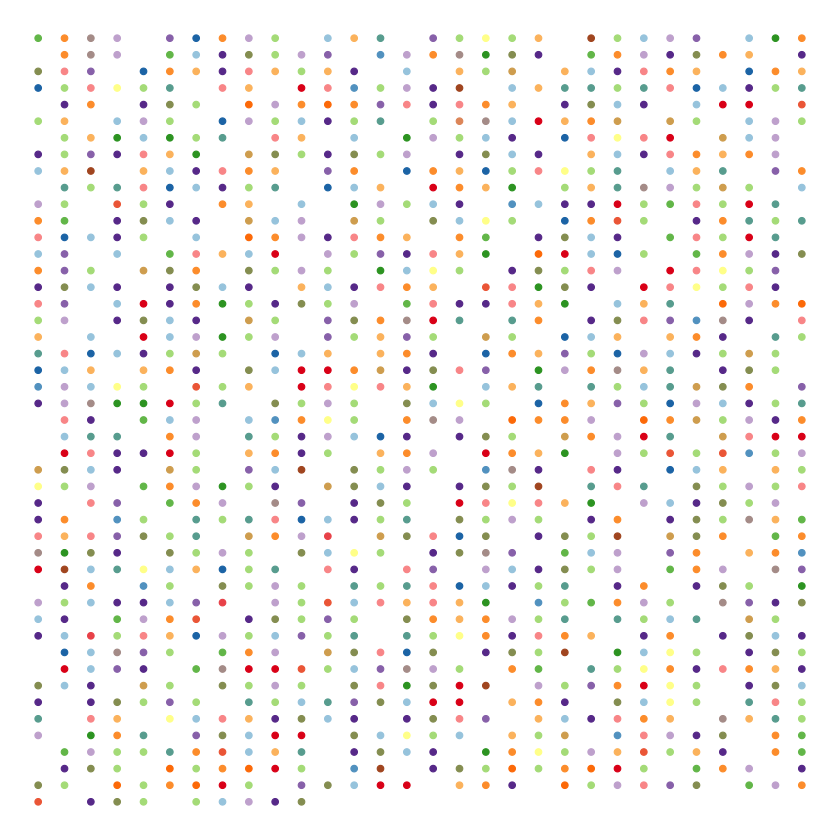

In [149]:
graphmain <- df %>%
  filter(is.na(letter)==FALSE & letter!= " ") %>%
  ggplot(aes(x=xpos, y=ypos, col=as.factor(letter))) +
  geom_point() +
  theme_void() +
  scale_color_manual(values=mycolors) +
  theme(legend.position = "none")
graphmain

Note that the number of dots correspond to the number of letters in the words, starting with "four score and seven years ago". Everything is in order.

## Creating title
To improve the presentation we will now create a title for the graph, and a legend. In order to have full control over them we will make them as separate graphs, and then combine the three graphs into one. In essence it means that we will go through the same procedure as above for both the title and the legend.

The idea is that the title should serve as a key to the graph, a hint, as it will have both the actual letters and the colors. But then of course we need to use the same colors for the letters as we do in the graph. This requires a bit of extra work.

In [150]:
# Split title into parts, assign x position (y is a constant), and create a data frame
# with x position and the letter
letter_title <- as.vector(str_split_fixed(titletext, "", n = nchar(titletext)))
xpos_title <- 1:length(letter_title)
df_title <- as.data.frame(xpos_title)
df_title <- cbind(df_title, letter_title)

# List of letters occuring in the title
letterlist_title <- as.data.frame(tolower(levels(as.factor(letter_title)))) %>%
  rename("ltr" = 1) %>%
  filter(ltr!=" ")
  
# Match the letters in the title to the main palette, and create a new palette
letterlist_title <- left_join(letterlist_title, colorlist, by = "ltr")
mycolors_title <- as.vector(letterlist_title[,2])

Warning message:
“Column `ltr` joining factors with different levels, coercing to character vector”


Now we are ready to create the title graph - it looks a bit strange right now, but it will fit in nicely later when we combine them all together. The letters are displayed through `geom_text`, nudged upwards from the points.

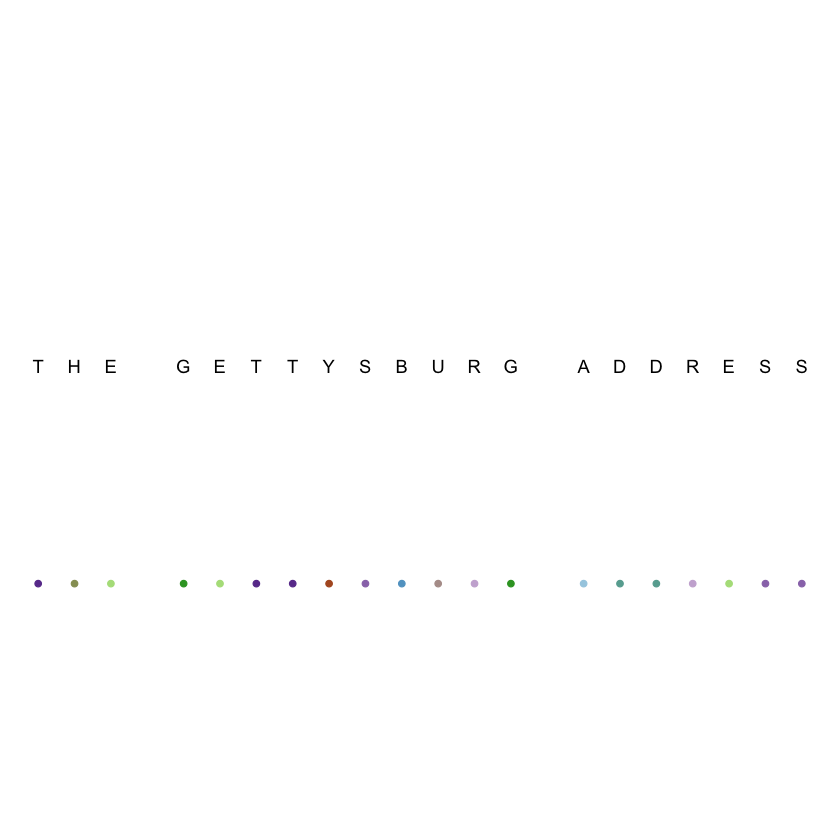

In [151]:
graphtitle <- df_title %>%
  filter(letter_title!=" ") %>%
  ggplot(aes(x=xpos_title, y=1, col=as.factor(letter_title), label=letter_title)) +
  geom_point() +
  geom_text(nudge_y = 1, col = "black") +
  theme_void() +
  scale_color_manual(values=mycolors_title) +
  theme(legend.position = "none") +
  ylim(0, 3.5)

graphtitle

## Creating a legend
And now for the legend - I want it below the graph, with the letters displayed below the colored dots. This is easier, since we can use the normal palette.

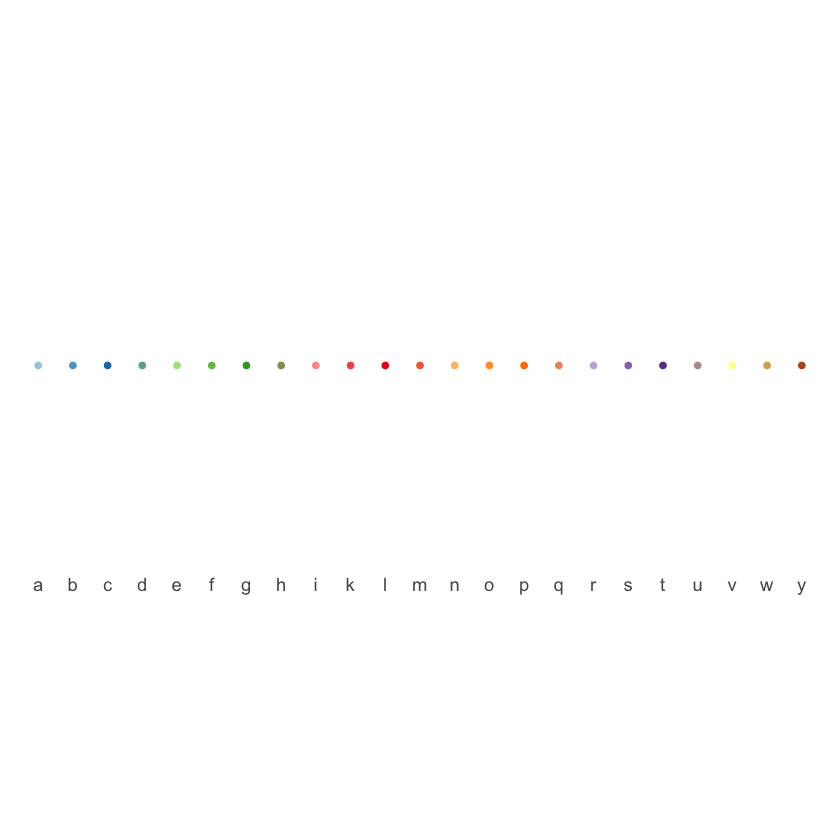

In [152]:
xpos_legend <- 1:nrcolors # X position
df_legend <- as.data.frame(xpos_legend) # Create data frame
df_legend <- cbind(df_legend, letterlist) # Combine with the lett

graphlegend <- df_legend %>%
  ggplot(aes(x=xpos_legend, y=1, col=as.factor(letterlist), label=letterlist)) +
  geom_point() +
  geom_text(nudge_y = -1, col = "#555555") +
  theme_void() +
  scale_color_manual(values=mycolors) +
  theme(legend.position = "none") +
  ylim(-1, 2.5)
graphlegend

## Putting the graph together
Now we just combine the three parts of the graph with `ggarrange` from the package `ggpubr`. We specify that the main part should be 14 times higher than the title and legend.

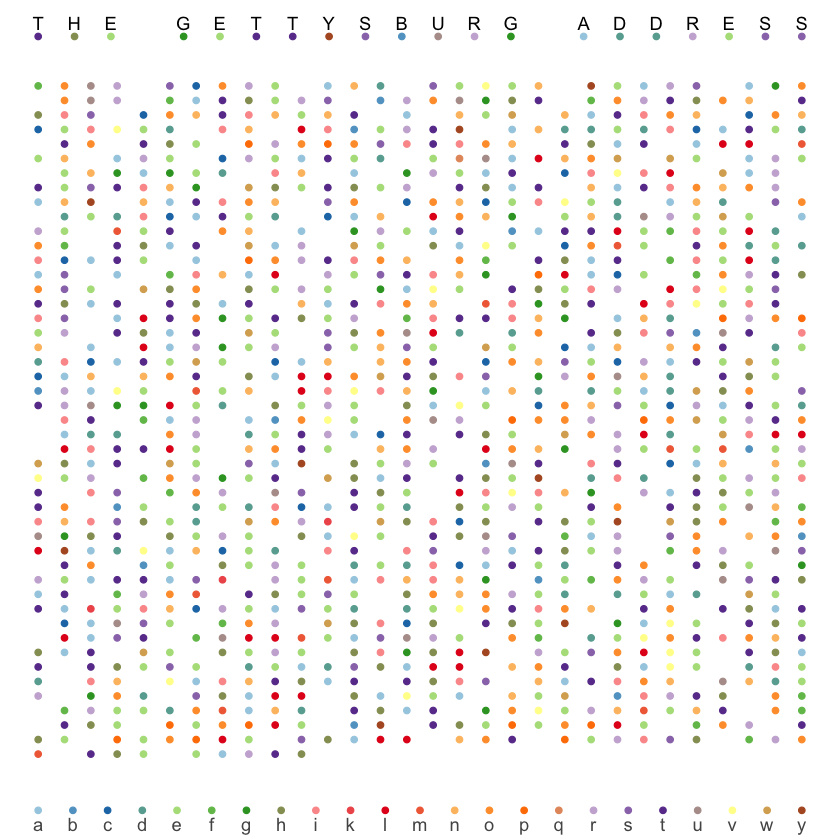

In [153]:
ggarrange(graphtitle, graphmain, graphlegend, nrow = 3, ncol = 1, heights = c(1, 14, 1))

It works! Now we can export it to a pdf or png. We can also easily change the text to something else. Here is John Lennon's Imagine (with 20 columns and the "accent" palette):

![](finalgraph_imagine.png)